In [34]:
import pandas as pd
import numpy as np
import gpxpy

gpx_file_path = "./activity_17507807930.gpx"
csv_file_path = "./2024-11-10-15-59_acceleration.csv"

# Load and preprocess the GPS data
def load_gps_data(gpx_file_path):
    # Earth's radius in meters
    R = 6371000
    
    # Load the GPX file
    with open(gpx_file_path, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)

    # Variables for previous point coordinates
    previous_lat = None
    previous_lon = None
    x, y = 0, 0  # cumulative x, y coordinates

    # List to store GPS data points
    gps_data_points = []

    # Process GPS data points
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                if previous_lat is not None and previous_lon is not None:
                    # Calculate the distance between points
                    lat1, lon1 = np.radians(previous_lat), np.radians(previous_lon)
                    lat2, lon2 = np.radians(point.latitude), np.radians(point.longitude)
                    delta_lat = lat2 - lat1
                    delta_lon = lon2 - lon1
                    a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2) ** 2
                    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
                    distance = R * c
                    dx = distance * np.cos(delta_lon)
                    dy = distance * np.sin(delta_lon)
                    x += dx
                    y += dy
                else:
                    distance, dx, dy = 0, 0, 0

                # Append data to list with Unix timestamp
                gps_data_points.append({
                    'Timestamp': point.time.timestamp(),  # Convert to Unix timestamp
                    'Latitude': point.latitude,
                    'Longitude': point.longitude,
                    'Elevation': point.elevation,
                    'Distance_to_previous': distance,
                    'Cumulative_X': x,
                    'Cumulative_Y': y
                })

                # Update previous point
                previous_lat = point.latitude
                previous_lon = point.longitude

    # Create DataFrame from GPS data
    gps_df = pd.DataFrame(gps_data_points)

    # Set index to 'Timestamp' and resample to 20Hz
    gps_df['Timestamp'] = pd.to_datetime(gps_df['Timestamp'], unit='s')
    gps_df.set_index('Timestamp', inplace=True)
    gps_resampled_df = gps_df.resample('50ms').interpolate(method='linear').reset_index()

    # Convert the resampled timestamps back to Unix time
    gps_resampled_df['Timestamp'] = gps_resampled_df['Timestamp'].astype(np.int64) / 1e9  # Convert to seconds
    
    return gps_resampled_df

# Load and preprocess the Accelerometer data
def load_accelerometer_data(csv_file_path):
    # Load the data and display the first few rows to inspect the raw format
    accel_data = pd.read_csv(csv_file_path, sep=';', engine='python')
    print("Raw Accelerometer Data:")
    print(accel_data.head())  # Display raw data from CSV

    # Ensure the timestamp is in Unix format
    accel_data['Timestamp'] = pd.to_numeric(accel_data['Timestamp'], errors='coerce')

    # Drop rows with NaT values in the Timestamp column
    accel_data = accel_data.dropna(subset=['Timestamp'])

    # Convert acceleration columns to numeric, forcing errors to NaN if there are any non-numeric values
    accel_data['AccelerationX'] = pd.to_numeric(accel_data['AccelerationX'], errors='coerce')
    accel_data['AccelerationY'] = pd.to_numeric(accel_data['AccelerationY'], errors='coerce')
    accel_data['AccelerationZ'] = pd.to_numeric(accel_data['AccelerationZ'], errors='coerce')

    # Display the cleaned DataFrame for further inspection
    print("Cleaned Accelerometer Data:")
    print(accel_data)

    return accel_data

# Load the data files
gps_resampled_df = load_gps_data(gpx_file_path)
accel_data = load_accelerometer_data(csv_file_path)

# Check if both dataframes are populated
print("GPS Data Sample:")
print(gps_resampled_df.head())
print("Accelerometer Data Sample:")
print(accel_data.head())

# Merge the data on the nearest timestamp
merged_data = pd.merge_asof(
    accel_data.sort_values('Timestamp'), 
    gps_resampled_df.sort_values('Timestamp'), 
    on='Timestamp', 
    direction='nearest'
)

# Display the merged data
print("Merged Data Sample:")
print(merged_data[['Timestamp', 'AccelerationX', 'AccelerationY', 'Cumulative_X', 'Cumulative_Y']].head(10))

# After merging the data, filter the required columns
filtered_data = merged_data[['Timestamp', 'AccelerationX', 'AccelerationY', 'Cumulative_X', 'Cumulative_Y']]

# Convert to a list of dictionaries to get a vector-like structure
final_vector = filtered_data.to_dict('records')

# Display the first few entries of the final vector for verification
print("\nFinal Vector Sample:")
for entry in final_vector[:]:  # Display the first 5 entries to check the result
    print(entry)


Raw Accelerometer Data:
                  Date     Timestamp DeviceOrientation  AccelerationX  \
0  2024-11-10 15:59:19  1.731276e+09          portrait       0.022018   
1  2024-11-10 15:59:19  1.731276e+09          portrait      -0.051422   
2  2024-11-10 15:59:19  1.731276e+09          portrait      -0.094009   
3  2024-11-10 15:59:19  1.731276e+09          portrait      -0.082642   
4  2024-11-10 15:59:19  1.731276e+09          portrait      -0.067078   

   AccelerationY  AccelerationZ  Label  
0      -0.138000      -0.878906    NaN  
1      -0.129639      -0.957733    NaN  
2      -0.206680      -0.911240    NaN  
3      -0.192932      -0.991898    NaN  
4      -0.148163      -0.997452    NaN  
Cleaned Accelerometer Data:
                    Date     Timestamp DeviceOrientation  AccelerationX  \
0    2024-11-10 15:59:19  1.731276e+09          portrait       0.022018   
1    2024-11-10 15:59:19  1.731276e+09          portrait      -0.051422   
2    2024-11-10 15:59:19  1.731276e+09

Now that we have both GPS acquired position (interpolated) and accelerometer data matched to the same timestamps, let's plot the calculated results to compare these two data to see where we are at:

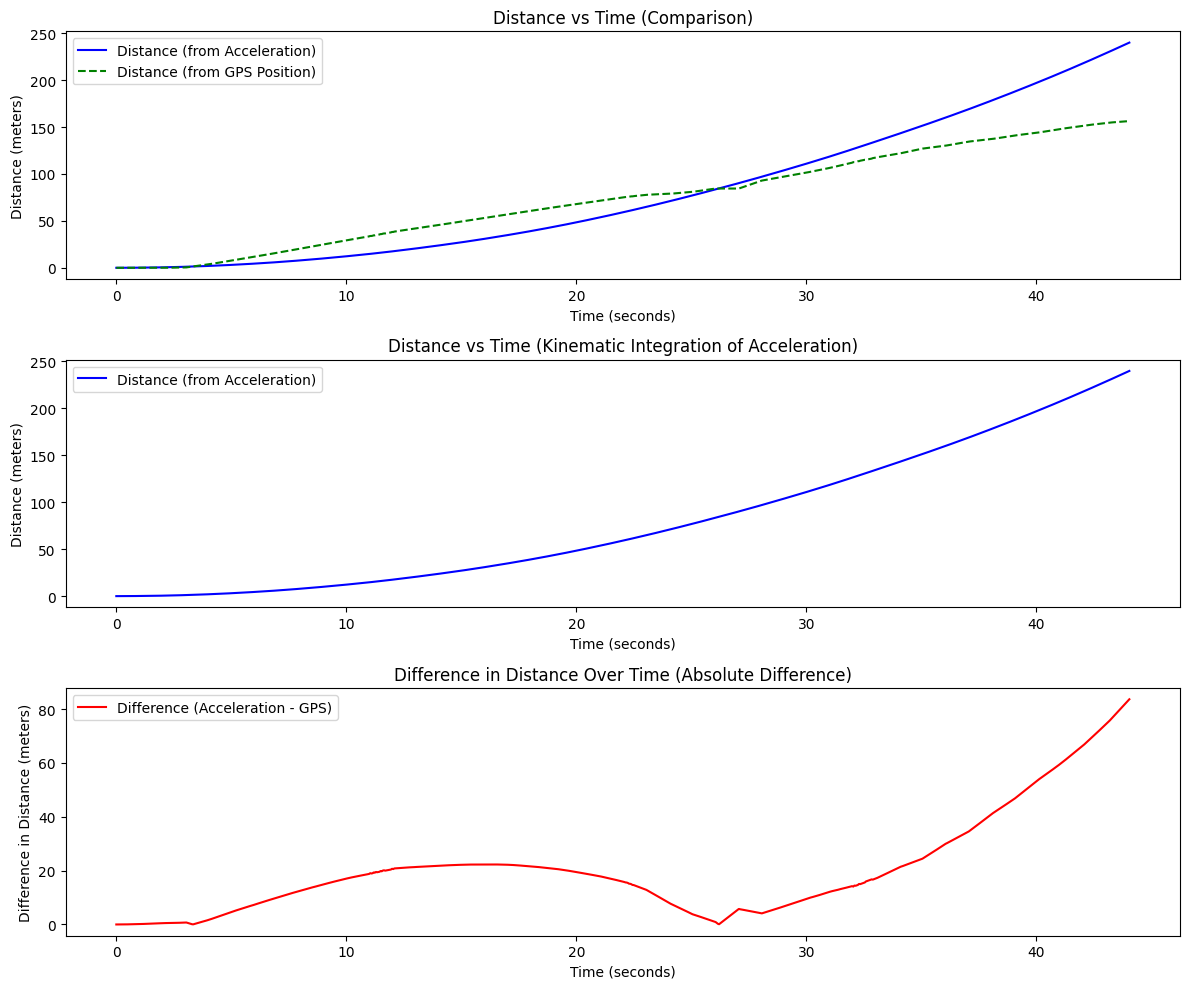

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Convert timestamps to seconds for easier calculations
merged_data['Timestamp'] = merged_data['Timestamp'] - merged_data['Timestamp'].iloc[0]  # start from zero
time_seconds = merged_data['Timestamp'].astype(float).to_numpy()

# Step 1: Calculate distance using kinematic integration of acceleration
velocity_x = np.zeros_like(time_seconds)
velocity_y = np.zeros_like(time_seconds)
distance_accel = np.zeros_like(time_seconds)

# Integrate acceleration to get velocity, and integrate velocity to get distance
for i in range(1, len(time_seconds)):
    dt = time_seconds[i] - time_seconds[i - 1]
    # Integrate to get velocity
    velocity_x[i] = velocity_x[i - 1] + merged_data['AccelerationX'].iloc[i] * dt
    velocity_y[i] = velocity_y[i - 1] + merged_data['AccelerationY'].iloc[i] * dt
    # Integrate to get distance
    distance_accel[i] = distance_accel[i - 1] + np.sqrt(velocity_x[i]**2 + velocity_y[i]**2) * dt

# Step 2: Calculate distance from GPS position data
distance_position = np.sqrt(merged_data['Cumulative_X']**2 + merged_data['Cumulative_Y']**2).to_numpy()

# Step 3: Calculate the absolute difference between the two distances
distance_difference = np.abs(distance_accel - distance_position)

# Step 4: Plotting
plt.figure(figsize=(12, 10))

# Plot both distances on the same plot for comparison
plt.subplot(3, 1, 1)
plt.plot(time_seconds, distance_accel, label="Distance (from Acceleration)", color='blue')
plt.plot(time_seconds, distance_position, label="Distance (from GPS Position)", color='green', linestyle='--')
plt.xlabel("Time (seconds)")
plt.ylabel("Distance (meters)")
plt.title("Distance vs Time (Comparison)")
plt.legend()

# Plot distance from kinematic integration of acceleration
plt.subplot(3, 1, 2)
plt.plot(time_seconds, distance_accel, label="Distance (from Acceleration)", color='blue')
plt.xlabel("Time (seconds)")
plt.ylabel("Distance (meters)")
plt.title("Distance vs Time (Kinematic Integration of Acceleration)")
plt.legend()

# Plot the absolute difference between the two distances
plt.subplot(3, 1, 3)
plt.plot(time_seconds, distance_difference, label="Difference (Acceleration - GPS)", color='red')
plt.xlabel("Time (seconds)")
plt.ylabel("Difference in Distance (meters)")
plt.title("Difference in Distance Over Time (Absolute Difference)")
plt.legend()

plt.tight_layout()
plt.show()
